In [4]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [5]:
filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [8]:
df = pd.read_csv("/content/amazon_reviews.csv", sep=",")
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,0528881469,"[0, 0]",5.00,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200.00
1,1,0528881469,"[12, 15]",1.00,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200.00
2,2,0528881469,"[43, 45]",3.00,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400.00
3,3,0528881469,"[9, 10]",2.00,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800.00
4,4,0528881469,"[0, 0]",1.00,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      999 non-null    int64  
 1   asin            999 non-null    object 
 2   helpful         999 non-null    object 
 3   overall         999 non-null    float64
 4   reviewText      997 non-null    object 
 5   reviewTime      999 non-null    object 
 6   reviewerID      999 non-null    object 
 7   reviewerName    994 non-null    object 
 8   summary         999 non-null    object 
 9   unixReviewTime  999 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.2+ KB


##Text Processing

In [10]:
# Normalizing Case Folding
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [11]:
import nltk

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
# Stopwords

sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [14]:
# Rarewords

drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
# Tokenization

# nltk.download("punkt")
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0    [got, gps, husband, otr, road, trucker, impres...
1    [im, professional, otr, truck, driver, bought,...
2    [well, say, ive, unit, truck, four, days, prio...
3    [going, write, long, review, even, thought, un...
4    [ive, mine, year, heres, got, tries, route, no...
Name: reviewText, dtype: object

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
# Lemmatization

# Kelimeleri köklerine ayırma işlemidir.
# nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0    got gps husband otr road trucker impressed shi...
1    im professional otr truck driver bought tnd tr...
2    well say ive unit truck four day prior garmin ...
3    going write long review even thought unit dese...
4    ive mine year here got try route non truck rou...
5    using nook hd work described hd picture samsun...
6    cable wobbly sometimes disconnect itselfthe pr...
7    adaptor real easy setup use right box problem ...
8    adapter easily connects nook hd hdtv hdmi cabl...
9    product really work great found following item...
Name: reviewText, dtype: object

##Text Visualization

In [19]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,worked,98.00
1,within,23.00
2,freezing,4.00
3,ease,22.00
4,great,422.00


In [20]:
tf.shape

(7739, 2)

In [21]:
tf["words"].nunique()

7739

In [22]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   7739.00
mean       9.28
std       36.47
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        5.00
80%        6.00
90%       18.00
95%       37.10
99%      139.86
max     1516.00
Name: tf, dtype: float64

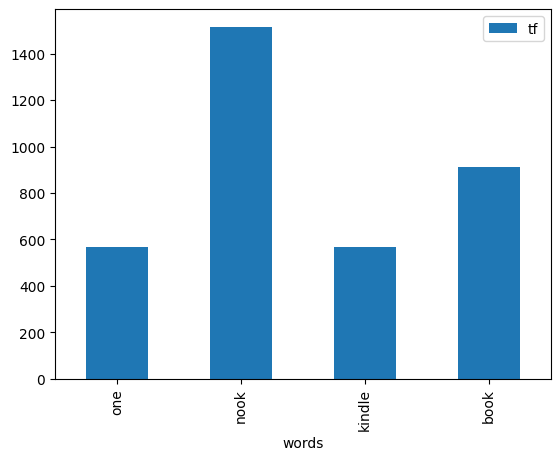

In [23]:
# Barplot

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

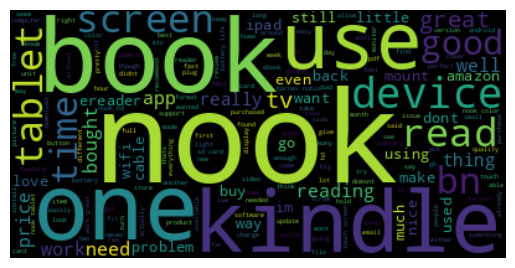

In [24]:
# Wordcloud

text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

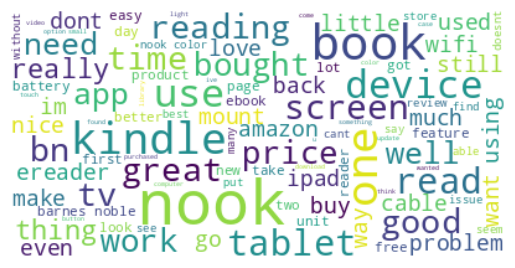

In [25]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

##Sentiment Analysis

In [26]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,0528881469,"[0, 0]",5.00,got gps husband otr road trucker impressed shi...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200.00
1,1,0528881469,"[12, 15]",1.00,im professional otr truck driver bought tnd tr...,"11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200.00
2,2,0528881469,"[43, 45]",3.00,well say ive unit truck four day prior garmin ...,"09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400.00
3,3,0528881469,"[9, 10]",2.00,going write long review even thought unit dese...,"11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800.00
4,4,0528881469,"[0, 0]",1.00,ive mine year here got try route non truck rou...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400.00


In [27]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [28]:
sia = SentimentIntensityAnalyzer()

In [29]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [30]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [31]:
df["reviewText"].apply(lambda x: x.upper())

0      GOT GPS HUSBAND OTR ROAD TRUCKER IMPRESSED SHI...
1      IM PROFESSIONAL OTR TRUCK DRIVER BOUGHT TND TR...
2      WELL SAY IVE UNIT TRUCK FOUR DAY PRIOR GARMIN ...
3      GOING WRITE LONG REVIEW EVEN THOUGHT UNIT DESE...
4      IVE MINE YEAR HERE GOT TRY ROUTE NON TRUCK ROU...
                             ...                        
994    CABLE RUN LIFETIME EXCELLENT PRODUCT LONGER WE...
995    QUALITY CONNECTION VIDEO SEEMS GOOD FUJIFILM F...
996    SAY NEEDED CABLE RUN CAMERA TV NEEDED WORK EXP...
997    FIND NOTHING WRONG CABLE WORK PERFECTLY GREAT ...
998    WORK PERFECTLY P HD CANON EOS MODE COST LE PRI...
Name: reviewText, Length: 999, dtype: object

In [32]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.029, 'neu': 0.638, 'pos': 0.332, 'co...
1    {'neg': 0.103, 'neu': 0.805, 'pos': 0.092, 'co...
2    {'neg': 0.069, 'neu': 0.792, 'pos': 0.139, 'co...
3    {'neg': 0.097, 'neu': 0.79, 'pos': 0.113, 'com...
4    {'neg': 0.113, 'neu': 0.825, 'pos': 0.061, 'co...
5    {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...
6    {'neg': 0.236, 'neu': 0.764, 'pos': 0.0, 'comp...
7    {'neg': 0.092, 'neu': 0.679, 'pos': 0.228, 'co...
8    {'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'comp...
9    {'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...
Name: reviewText, dtype: object

In [33]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.98
1   -0.39
2    0.99
3    0.44
4   -0.78
5    0.57
6   -0.53
7    0.70
8    0.95
9    0.96
Name: reviewText, dtype: float64

In [34]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,polarity_score
0,0,0528881469,"[0, 0]",5.00,got gps husband otr road trucker impressed shi...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200.00,0.98
1,1,0528881469,"[12, 15]",1.00,im professional otr truck driver bought tnd tr...,"11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200.00,-0.39
2,2,0528881469,"[43, 45]",3.00,well say ive unit truck four day prior garmin ...,"09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400.00,0.99
3,3,0528881469,"[9, 10]",2.00,going write long review even thought unit dese...,"11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800.00,0.44
4,4,0528881469,"[0, 0]",1.00,ive mine year here got try route non truck rou...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400.00,-0.78


##Sentiment Modelling

In [35]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    neg
2    pos
3    pos
4    neg
5    pos
6    neg
7    pos
8    pos
9    pos
Name: reviewText, dtype: object

In [36]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(20)

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,polarity_score,sentiment_label
0,0,0528881469,"[0, 0]",5.00,got gps husband otr road trucker impressed shi...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200.00,0.98,pos
1,1,0528881469,"[12, 15]",1.00,im professional otr truck driver bought tnd tr...,"11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200.00,-0.39,neg
2,2,0528881469,"[43, 45]",3.00,well say ive unit truck four day prior garmin ...,"09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400.00,0.99,pos
3,3,0528881469,"[9, 10]",2.00,going write long review even thought unit dese...,"11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800.00,0.44,pos
4,4,0528881469,"[0, 0]",1.00,ive mine year here got try route non truck rou...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400.00,-0.78,neg
5,5,0594451647,"[3, 3]",5.00,using nook hd work described hd picture samsun...,"01 3, 2014",A2JXAZZI9PHK9Z,"Billy G. Noland ""Bill Noland""",HDMI Nook adapter cable,1388707200.00,0.57,pos
6,6,0594451647,"[0, 0]",2.00,cable wobbly sometimes disconnect itselfthe pr...,"04 27, 2014",A2P5U7BDKKT7FW,Christian,Cheap proprietary scam,1398556800.00,-0.53,neg
7,7,0594451647,"[0, 0]",5.00,adaptor real easy setup use right box problem ...,"05 4, 2014",AAZ084UMH8VZ2,"D. L. Brown ""A Knower Of Good Things""",A Perfdect Nook HD+ hook up,1399161600.00,0.70,pos
8,8,0594451647,"[0, 0]",4.00,adapter easily connects nook hd hdtv hdmi cabl...,"07 11, 2014",AEZ3CR6BKIROJ,Mark Dietter,A nice easy to use accessory.,1405036800.00,0.95,pos
9,9,0594451647,"[3, 3]",5.00,product really work great found following item...,"01 20, 2014",A3BY5KCNQZXV5U,Matenai,This works great but read the details...,1390176000.00,0.96,pos


In [37]:
df["sentiment_label"].value_counts()

pos    858
neg    141
Name: sentiment_label, dtype: int64

In [38]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   3.43
pos   4.25
Name: overall, dtype: float64

In [39]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [40]:
X = df["reviewText"]
y = df["sentiment_label"]

In [41]:
# ngram
a = """A longer text for better understanding. N-grams show combinations of words used together and are used to generate features."""
TextBlob(a).ngrams(3)

[WordList(['A', 'longer', 'text']),
 WordList(['longer', 'text', 'for']),
 WordList(['text', 'for', 'better']),
 WordList(['for', 'better', 'understanding']),
 WordList(['better', 'understanding', 'N-grams']),
 WordList(['understanding', 'N-grams', 'show']),
 WordList(['N-grams', 'show', 'combinations']),
 WordList(['show', 'combinations', 'of']),
 WordList(['combinations', 'of', 'words']),
 WordList(['of', 'words', 'used']),
 WordList(['words', 'used', 'together']),
 WordList(['used', 'together', 'and']),
 WordList(['together', 'and', 'are']),
 WordList(['and', 'are', 'used']),
 WordList(['are', 'used', 'to']),
 WordList(['used', 'to', 'generate']),
 WordList(['to', 'generate', 'features'])]

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [43]:
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [44]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
feature_names = vectorizer2.get_feature_names_out()
X_n.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [45]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

# Getting feature names for the 10th to 14th features
feature_names_slice = vectorizer.get_feature_names_out()[10:15]
print(feature_names_slice)

# Getting the transformed matrix for the 10th to 14th samples
X_count_slice = X_count.toarray()[10:15]
print(X_count_slice)

['abundance' 'abuse' 'abused' 'abusednot' 'ac']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##TF_IDF


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word')
X_w = vectorizer.fit_transform(corpus)

# Getting feature names
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

# Getting the TF-IDF matrix
tfidf_matrix = X_w.toarray()
print(tfidf_matrix)

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_n = vectorizer.fit_transform(corpus)

# Getting feature names
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

# Getting the TF-IDF matrix
tfidf_matrix = X_n.toarray()
print(tfidf_matrix)

['and this' 'and this is' 'document is' 'document is the' 'first document'
 'is the' 'is the first' 'is the second' 'is the third' 'is this'
 'is this the' 'second document' 'the first' 'the first document'
 'the second' 'the second document' 'the third' 'the third one'
 'third one' 'this document' 'this document is' 'this is' 'this is the'
 'this the' 'this the first']
[[0.         0.         0.         0.         0.37102749 0.30037873
  0.47060133 0.         0.         0.         0.         0.
  0.37102749 0.37102749 0.         0.         0.         0.
  0.         0.         0.         0.37102749 0.37102749 0.
  0.        ]
 [0.         0.         0.34488069 0.34488069 0.         0.22013288
  0.         0.34488069 0.         0.         0.         0.34488069
  0.         0.         0.34488069 0.34488069 0.         0.
  0.         0.34488069 0.34488069 0.         0.         0.
  0.        ]
 [0.36153669 0.36153669 0.         0.         0.         0.23076418
  0.         0.         0.3

In [48]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

##Model

In [49]:
# Logistic Regression

log_model = LogisticRegression().fit(X_tf_idf_word, y)


In [50]:
# Cross-validation
accuracy = cross_val_score(log_model, X_tf_idf_word, y, scoring="accuracy", cv=5).mean()
print("Cross-Validation Accuracy:", accuracy)

Cross-Validation Accuracy: 0.8588592964824121


In [51]:
new_review = pd.Series("this product is great")
new_review = pd.Series("look at that shit very bad")
new_review = pd.Series("it was good but I am sure that it fits me")

In [52]:
new_review = CountVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([1])

In [53]:
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    got mounting tv wall home office price good wo...
dtype: object

In [54]:
new_review = CountVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

array([1])

##Random Forest

In [55]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8618643216080402

In [56]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8608592964824121

In [57]:
# Hyperparameter Optimization
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [58]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [59]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

In [60]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

In [61]:
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Mean F1-score:", cv_results['test_f1'].mean())
print("Mean ROC AUC:", cv_results['test_roc_auc'].mean())

Mean Accuracy: 0.8608608608608609
Mean F1-score: 0.9250679228250318
Mean ROC AUC: 0.6658483360611019


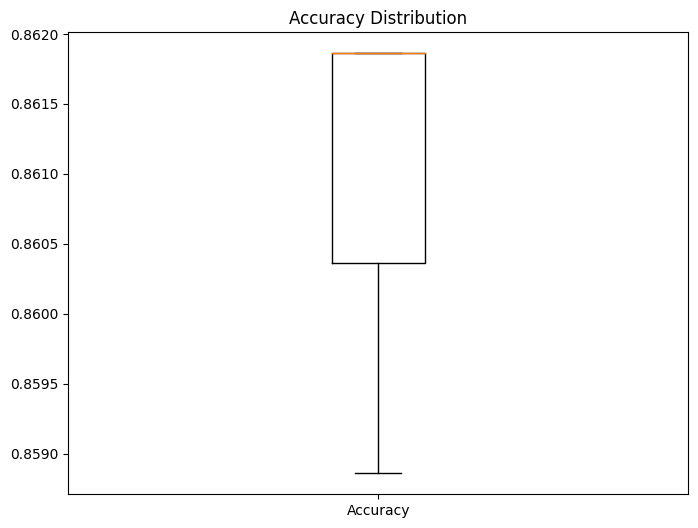

In [62]:
import matplotlib.pyplot as plt

# Box plot for accuracy
plt.figure(figsize=(8, 6))
plt.boxplot(cv_results['test_accuracy'], labels=["Accuracy"])
plt.title("Accuracy Distribution")
plt.show()

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_final, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_count, y)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy: 0.8608608608608609


In [64]:
feature_importance = rf_final.feature_importances_

In [65]:
print("Model Interpretation- most influenced feature: ",feature_importance)

Model Interpretation- most influenced feature:  [4.48258455e-06 7.62508374e-05 2.14003191e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


#Save the model

In [66]:
import joblib

In [67]:
joblib.dump(rf_final, 'sentiment_analysis_model.pkl')

['sentiment_analysis_model.pkl']